# Project: **Finding Lane Lines on the Road** 
Author: Toshiharu Tabuchi

## **Introduction**
In this project, a computer vision pipeline was developed in order to identified the lane lines on the highway. The topics covered in this project were:

- Opencv (python frontend)
- Image region masking
- Canny function for edge detection
- Hough transformation for identifying consecutive line segments (and therefore, the lanes).
- Polynomial fitting for obtaining the curve equation for  further processing.

## **Part 1: Lane line identification on static images**

filename = Lane_detect_images.py

### Import packages

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

import glob, os
%matplotlib inline

### Functions definition

**Some notes:**
After the Hough transform algorithm is applied, the obtained (x,y) points from the identified segments are used to obtain the curve parameters with the function **Lane_lines_fit**. Two sets of parameters, each for the left and right lane lines are given by this function. 
After that, the identified curves can be plotted using the **drawLines** function.

In [8]:
def grayscale(img):
    # Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def colorFilter(img,bgr,thresh):
    """
    Isolate certain color range of image
    To isolate multiple colors, isolate them separately and bitwise added them
    color is assumed in RGB format
    """
    minBGR = np.array([bgr[0] - thresh, bgr[1] - thresh, bgr[2] - thresh])
    maxBGR = np.array([bgr[0] + thresh, bgr[1] + thresh, bgr[2] + thresh])
    return cv2.inRange(img,minBGR,maxBGR)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussianBlur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = np.copy(image)*0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), (255,0, 0), thickness=2)
## For debugging   
#    comb_img = cv2.addWeighted(image, 0.8, line_img, 1,0.5)
#    plt.figure()        
#    plt.imshow(comb_img)
#   draw_lines(line_img, lines)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



In [ ]:
def roi(img, vertices):
    """
    Applies an image mask.
        Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    """defining a blank mask to start with"""
    mask = np.zeros_like(img)   
    
    """defining a 3 channel or 1 channel color to fill the mask with depending
    on the input image
    """
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    """filling pixels inside the polygon defined by "vertices" with the
    fill color    
    """
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    plt.figure()
    plt.imshow(image)
    plt.contour(mask,colors='b',linestyles='dashed')
    
    """returning the image only where mask pixels are nonzero"""
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
def Lane_lines_fit(houghLines,poly_degree=1):
    """
    The Lane_lines_fit function output the left and right polynomial curve parameters using the points obtained from the Hough transformation. This parameters are identified using the polyfit function. The user can define the polynomial's degree to find a better match. 
    For lines, the degree is set to 1
    """
    leftPoints  =[[],[]]
    rightPoints =[[],[]]
    leftCurve = np.zeros(shape=(1,2))
    rightCurve = np.zeros(shape=(1,2))
    
    for line in houghLines:
        for x1,y1,x2,y2 in line:
            #if m< 0, left line
            if ((y1-y2)/(x1-x2))<0:
                leftPoints=np.append(leftPoints,[[x1,x2],[y1,y2]],axis=1)
            else:
               rightPoints=np.append(rightPoints,[[x1,x2],[y1,y2]],axis=1)
    
#    print(rightPoints)
    leftCurve=np.polyfit(leftPoints[1,:],leftPoints[0,:],poly_degree)  #    x=f(y)
    rightCurve=np.polyfit(rightPoints[1,:],rightPoints[0,:],poly_degree)  # x=f(y)
   
    return leftCurve,rightCurve

In [ ]:
def drawLines(img,leftCurve,rightCurve,verLim):
    """
    This function takes an image, and the curve equation of the left and right
    lanes. Then, it draws this two curves over the image. 

    By default, both equation start at the bottom of the figure and finish at
    y = verLim
    """
    """ Left line initial and end points"""
    imshape = img.shape
    y1_left = imshape[0]
    x1_left = int(y1_left*leftCurve[0]+leftCurve[1])
    
    y2_left = verLim
    x2_left = int(y2_left*leftCurve[0]+leftCurve[1])
    
    """ Right line initial and end points """
    y1_right = imshape[0]
    x1_right = int(y1_right*rightCurve[0]+rightCurve[1])
    
    y2_right = 350
    x2_right = int(y2_right*rightCurve[0]+rightCurve[1])
    
    fit_line_image = np.copy(img)*0
    
    """ Drawing the curves """
    cv2.line(fit_line_image,(x1_left,y1_left),(x2_left,y2_left),(255,0,0),10)
    cv2.line(fit_line_image,(x1_right,y1_right),(x2_right,y2_right),(255,0,0),10)
    
    """
    Overlaying the curves on the input image, applying a previous transparency
    transformation
    """
    return  weighted_img(image,fit_line_image,0.8,1,0)

### Define input and ouput image folders 


In [9]:
imagesFolder = "test_images"
outputFolder = "images_output"


### Loop for processing all the images
The for loop scan all the images in the declared input folder. At the end of each loop, the output image with the identified lanes over is shown in the console, and also saved in the output folder

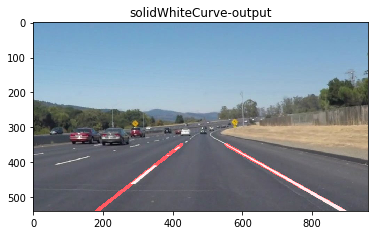

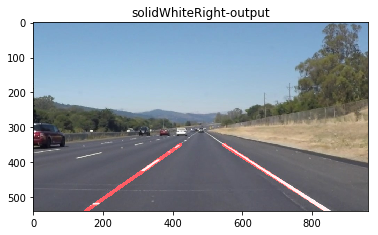

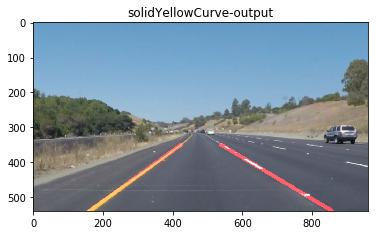

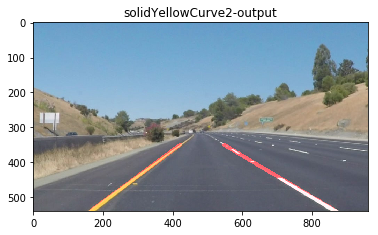

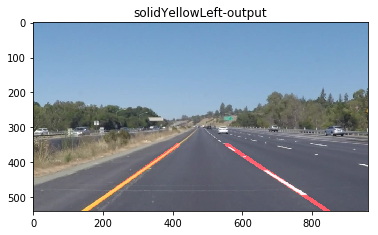

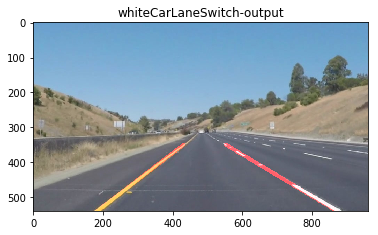

In [16]:
for file in os.listdir(imagesFolder):
    if file.endswith(".jpg"):
        image = mpimg.imread(imagesFolder+"/"+file)
    
        imshape = image.shape
        gray = gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
            
        """ Define a kernel size and apply Gaussian smoothing """
        blur_gray = gaussianBlur(gray,kernel_size=5)
        
        """ Define our parameters for Canny and apply """
        low_threshold = 50
        high_threshold = 200
        edges = canny(blur_gray, low_threshold, high_threshold)
        
        """ Masking Region of interest"""
        vertices = np.array([[(0,imshape[0]),(450, 300), (500,300), (imshape[1],imshape[0])]], dtype=np.int32)
        masked_edges = roi(edges,vertices)
        
        """
        Define the Hough transform parameters
        Make a blank the same size as our image to draw on
        """
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 60  #1   # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 20 #5 #minimum number of pixels making up a line
        max_line_gap = 15 #1   # maximum gap in pixels between connectable line segments
        line_image = np.copy(image)*0 # creating a blank to draw lines on
        
        """ Run Hough on edge detected image"""
        houghLines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
        #print(houghLines)
        
        """ Identified the curve equation of each, left and right lanes"""
        leftCurve,rightCurve = Lane_lines_fit(houghLines,poly_degree=1)
        
        verLim = 350 # Vertical limit to draw the identified lane's curves
        output_img = drawLines(image,leftCurve,rightCurve,verLim)
        #print(file)
        plt.figure()
        plt.title(file[:-4]+'-output')
        plt.imshow(output_img)
        
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)  #change to RGB
        cv2.imwrite(outputFolder+"/"+file[:-4]+'-output.jpg',output_img)

## Part 2: Lane lines identification on sequence of images
